# Задание 2: Спрос

In [1]:
from typing import List, Dict, Any, Tuple, Union, Optional

from datetime import datetime, timedelta
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

import logging

logging.basicConfig()
logger = logging.getLogger("model")
logger.setLevel(logging.INFO)

## Данные

In [2]:
sales_df = pd.read_parquet("../hm/sales.parquet")
sales_df["ds"] = sales_df["ds"].astype(str)
sales_df.head()

,sku_id,gmv,orders_num,price,ds
283,284,121161.0,116,1044.49,20230601
302,303,10413.0,186,55.98,20230601
235,236,550034.0,2569,214.10,20230601
206,207,18895.0,250,75.58,20230601
245,246,264666.0,3232,81.89,20230601


In [3]:
base_df = pd.read_csv("../hm_solution/data/homework_5_1_1_solution.csv")
base_df["ds"] = base_df["ds"].astype(str)
base_df.head()

,sku_id,ds,gmv,orders_num
0,1,20240101,3.178754e+04,2289.615385
1,3,20240101,1.489777e+04,1097.846154
2,4,20240101,2.250486e+05,3871.461538
3,7,20240101,1.166771e+06,5239.000000
4,8,20240101,6.135953e+05,5803.142857


In [4]:
elasticity_df = pd.read_csv("../hm_solution/data/homework_5_1_2_solution.csv")
elasticity_df.head()

,sku_id,elasticity_gmv,elasticity_orders_num
0,1,-0.01,-0.091652
1,3,-0.01,-0.389979
2,4,-0.01,-0.010000
3,7,-0.01,-0.010000
4,8,-0.01,-0.010000


## Сборка датасета для предсказания

In [5]:
def calc_rolling_window(
    df: pd.DataFrame,
    window: int,
    col: str,
    lvl: str,
    shift: int,
) -> pd.DataFrame:
    df = df.sort_values(["ds", lvl])
    df["ts"] = pd.to_datetime(df["ds"].astype(str))
    df["col"] = df[col]
    rolling_df = df.set_index("ts")
    rolling_df = (
        rolling_df.groupby([lvl], group_keys=True)["col"]
        # используем shift, так как потом нам нужно предсказывать на N дней вперед:
        # для однородности датасета используем сдвиг на кол-во дат в предсказании
        .apply(
            lambda x: x.asfreq("1D")
            .rolling(window=window, closed="left", min_periods=0)
            .mean()
            .shift(shift)
        )
        .reset_index()
        .rename(columns={"col": f"rolling_{col}_w_{window}"})
    )
    df = df.merge(rolling_df, how="left", on=[lvl, "ts"])
    df = df.drop(columns=["ts", "col"])
    return df

In [6]:
def generate_date_list(start_date_str: str, end_date_str: str) -> List[str]:
    start_date = datetime.strptime(start_date_str, "%Y%m%d")
    end_date = datetime.strptime(end_date_str, "%Y%m%d")
    num_days = (end_date - start_date).days + 1
    return [
        (start_date + timedelta(days=i)).strftime("%Y%m%d") for i in range(num_days)
    ]

In [7]:
START_DS, END_DS = "20240101", "20240107"

# Считаем последние цены
df = sales_df.copy(deep=True)[["sku_id", "price", "ds"]]
df = df.sort_values(by=["sku_id", "ds"])
df = df.groupby("sku_id").last().reset_index()
df = df.drop(columns=["ds"])

# Расширяем датасет на разные даты
ds_list = generate_date_list(start_date_str=START_DS, end_date_str=END_DS)
ds_df = pd.DataFrame({"ds": ds_list})
df = df.merge(ds_df, how="cross")

# Конкатим с историческими данными
cols = df.columns.tolist()
df = pd.concat(
    [sales_df.copy(deep=True).sort_values(by=["sku_id", "ds"])[cols], df[cols]]
)

# Считаем нормализованную цену
df = calc_rolling_window(
    df=df,
    window=14,
    col="price",
    lvl="sku_id",
    shift=7,
)
df = df[df["ds"].between(START_DS, END_DS)]

# Мержим базовый спрос
df = df.merge(base_df, on=["sku_id", "ds"], how="left")

# Мержим эластичность
df = df.merge(elasticity_df, on="sku_id", how="left")

# Предсказываем спрос для разных цен
discounts_df = pd.DataFrame({"discount": np.arange(-0.1, 0.11, 0.02).round(2).tolist()})
df = df.join(discounts_df, how="cross")
df["price"] = df["price"] + df["price"] * df["discount"]
df["price_norm"] = df["price"] / df["rolling_price_w_14"]
df["gmv"] = df["gmv"] * pow(df["price_norm"], df["elasticity_gmv"])
df["orders_num"] = df["orders_num"] * pow(df["price_norm"], df["elasticity_orders_num"])
df["margin"] = df["gmv"] * 0.1 + df["gmv"] * df["discount"]
df = df[["sku_id", "discount", "orders_num", "gmv", "margin", "ds"]]
df.head()

,sku_id,discount,orders_num,gmv,margin,ds
0,1,-0.10,2363.433516,31897.783793,0.000000,20240101
1,1,-0.08,2358.677397,31890.773779,637.815476,20240101
2,1,-0.06,2354.032833,31883.916021,1275.356641,20240101
3,1,-0.04,2349.494916,31877.204077,1912.632245,20240101
4,1,-0.02,2345.059049,31870.631902,2549.650552,20240101


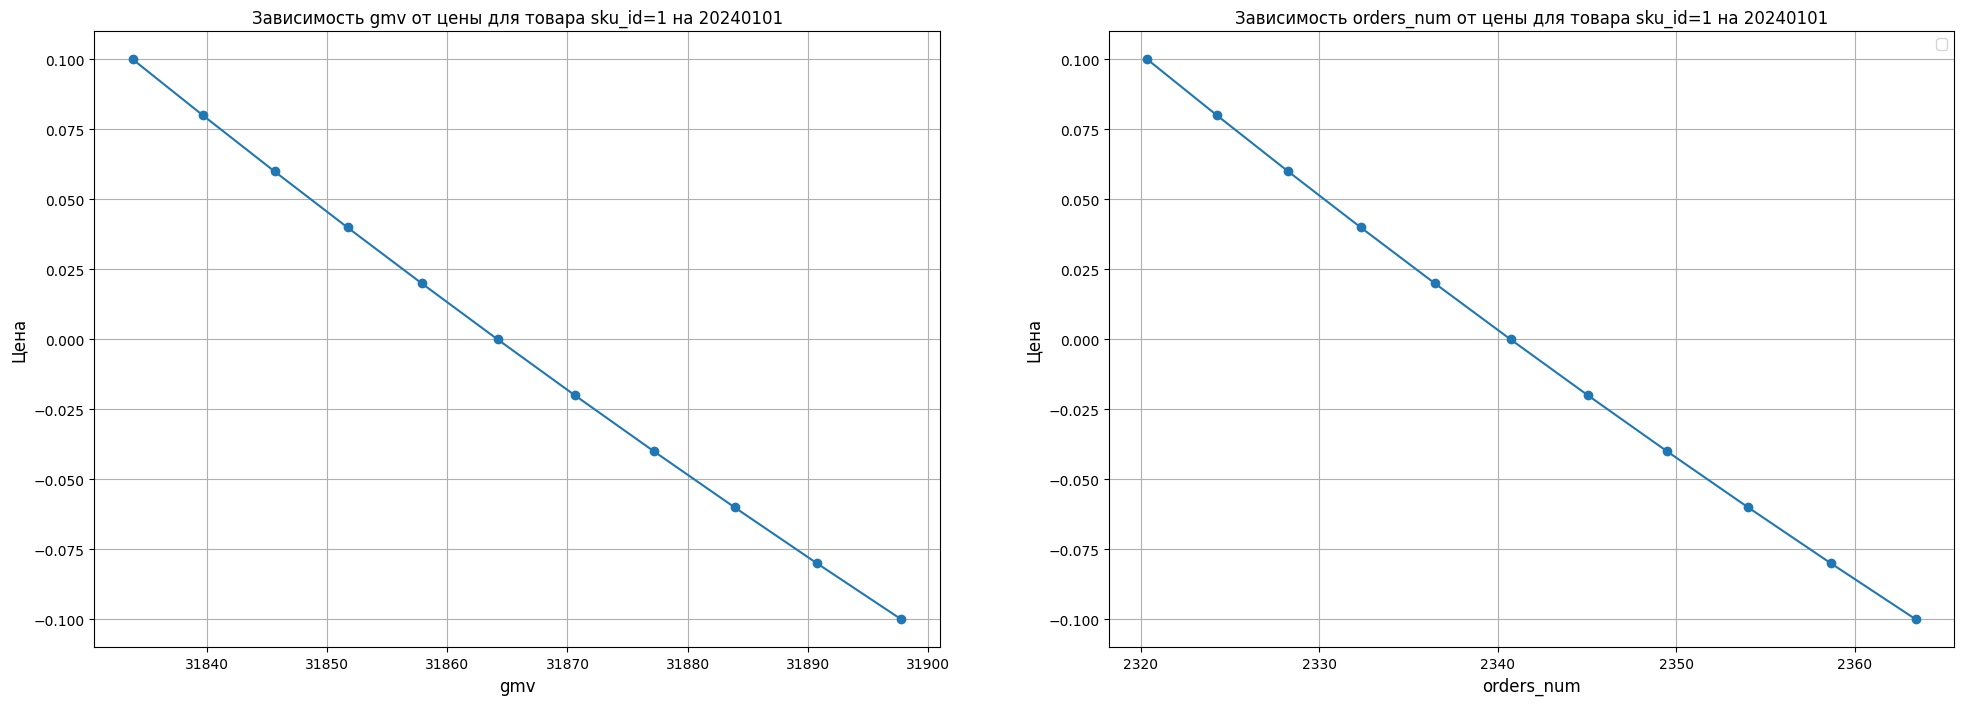

In [8]:
# Отрисуем кривую эластичности для товара
SKU_ID = 1
plot_df = df[(df["sku_id"] == SKU_ID) & (df["ds"] == START_DS)]
fig, axs = plt.subplots(1, 2, figsize=(24, 8))  # два графика в ряд
for id, metric in enumerate(("gmv", "orders_num")):
    axs[id].plot(plot_df[metric], plot_df["discount"], marker="o")
    axs[id].set_ylabel("Цена", fontsize=12)
    axs[id].set_xlabel(metric, fontsize=12)
    axs[id].set_title(
        f"Зависимость {metric} от цены для товара sku_id={SKU_ID} на {START_DS}",
        fontsize=12,
    )
    axs[id].grid(True)
plt.legend()
plt.show()

In [9]:
df.to_csv("../hm_solution/data/homework_5_2_solution.csv", index=False)